In [1]:
import pandas as pd
from os import listdir
import numpy as np
import random
import scipy.optimize as opt
import warnings
warnings.filterwarnings("ignore")
from Vasicek_one_factor import simulate_Vasicek_One_Factor

# Data

In [2]:
mypath = "Final"
data_list = listdir(mypath)

In [3]:
data = pd.DataFrame()
for col in data_list:
    tmp = pd.read_csv('Final/'+col, index_col = 'Date')
    data = pd.concat([data,tmp])
data.index = pd.DatetimeIndex(data.index)
df = pd.DataFrame(data.drop(['2 Mo','4 Mo'], axis=1).sort_index().copy())

In [4]:
for col in df.columns:
    df[col+'_shift'] = df[col].shift(1)
    df[col + '_diff'] = df[col] - df[col+'_shift']

In [5]:
db = df.dropna().copy()

# 估參數：k, theta , sigma

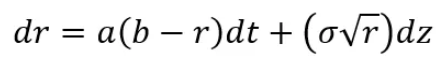

In [6]:
global N
N = 252
dt = 1/N
def fun_MLE(x): 
    
    random.seed(108)
    np.random.seed(108)
    # scipy
    DF = db_tmp.to_numpy()
    # print(DF)
    
    r0 = DF[:,0]
    r1 = DF[:,1]
    dr = DF[:,2]

    mu, sigma = 0, dt # mean and standard deviation
    s = np.random.normal(mu, sigma, len(DF))
    a = x[0]
    b = x[1]
    sigma = x[2]
    fit_dr =  a*(b-r0)*dt + sigma*np.sqrt(r0)*s
    error = np.sum(np.abs(fit_dr-dr))
    target = -np.log(error)
    # target = -error
    return target

In [7]:
initial = (0.3,0.3,0.3)
tmp = 1
constraints = ( {'type':'ineq','fun':lambda x : 2*x[0]*x[1]-x[2]**2},
                {'type':'ineq','fun':lambda x : x[2]},
                {'type':'ineq','fun':lambda x : -x[0]+1*tmp},
                {'type':'ineq','fun':lambda x : -x[1]+1*tmp},
                {'type':'ineq','fun':lambda x : -x[2]+1*tmp},
                {'type':'ineq','fun':lambda x : x[0]+1*tmp},
                {'type':'ineq','fun':lambda x : x[1]+1*tmp},
                {'type':'ineq','fun':lambda x : x[2]+1*tmp},
                )
# parameters = opt.minimize(fun_MLE, initial, method = 'SLSQP', constraints = constraints)
# bp = parameters['x']

# CIR

In [8]:
from CIR import CIR
import matplotlib.pyplot as plt

def estimate(bp,r0, period = 2):
    # assume mean-reverted speed = 1, mean-reverted level = 0.05, vol of interest rate = 0.05, initial interest rate = 0.05, and pass to an object named C
    V = simulate_Vasicek_One_Factor(r0, bp[0], bp[1], bp[2], dt*period, dt) 

    return np.array(V.iloc[1:])



# Rolling CIR

In [9]:
ROLLING = 30 #調整參數週期
dates = db[::ROLLING].index
period = 2 # 預測下一期
global db_tmp

In [10]:
DB = pd.DataFrame()
for j in range(0,11):
    bps = []
    for i in range(1,len(dates)):
        db_tmp = db[((db.index < dates[i]) & (db.index >= dates[i-1]))][db.columns[[j,j+11,j+12]]]
        # print(db_tmp.shape)
        parameters = opt.minimize(fun_MLE, initial, method = 'SLSQP', constraints = constraints)
        bp = parameters['x']
        bps.append(bp)
    df_pa = pd.DataFrame(bps, columns = [db.columns[j]+'_a',db.columns[j]+'_b',db.columns[j]+'_sigma'],index = dates[1:])
    df_pa_me =  pd.merge(db[db.columns[[j,j*2+11,j*2+12]]], df_pa, left_on = 'Date', right_on = 'Date',how = 'outer').ffill()
    print(df_pa_me.columns)
    DB_tmp = df_pa_me.dropna()
    DB = pd.concat([DB,DB_tmp],axis = 1)
    print(df_pa.shape, df_pa_me.shape, DB.shape)
Now_DB = DB.dropna().copy()
     

Index(['1 Mo', '1 Mo_shift', '1 Mo_diff', '1 Mo_a', '1 Mo_b', '1 Mo_sigma'], dtype='object')
(111, 3) (3358, 6) (3328, 6)
Index(['3 Mo', '3 Mo_shift', '3 Mo_diff', '3 Mo_a', '3 Mo_b', '3 Mo_sigma'], dtype='object')
(111, 3) (3358, 6) (3328, 12)
Index(['6 Mo', '6 Mo_shift', '6 Mo_diff', '6 Mo_a', '6 Mo_b', '6 Mo_sigma'], dtype='object')
(111, 3) (3358, 6) (3328, 18)
Index(['1 Yr', '1 Yr_shift', '1 Yr_diff', '1 Yr_a', '1 Yr_b', '1 Yr_sigma'], dtype='object')
(111, 3) (3358, 6) (3328, 24)
Index(['2 Yr', '2 Yr_shift', '2 Yr_diff', '2 Yr_a', '2 Yr_b', '2 Yr_sigma'], dtype='object')
(111, 3) (3358, 6) (3328, 30)
Index(['3 Yr', '3 Yr_shift', '3 Yr_diff', '3 Yr_a', '3 Yr_b', '3 Yr_sigma'], dtype='object')
(111, 3) (3358, 6) (3328, 36)
Index(['5 Yr', '5 Yr_shift', '5 Yr_diff', '5 Yr_a', '5 Yr_b', '5 Yr_sigma'], dtype='object')
(111, 3) (3358, 6) (3328, 42)
Index(['7 Yr', '7 Yr_shift', '7 Yr_diff', '7 Yr_a', '7 Yr_b', '7 Yr_sigma'], dtype='object')
(111, 3) (3358, 6) (3328, 48)
Index(['10 Yr', '

In [13]:
Now_DB 

,1 Mo,1 Mo_shift,1 Mo_diff,1 Mo_a,1 Mo_b,1 Mo_sigma,3 Mo,3 Mo_shift,3 Mo_diff,3 Mo_a,...,20 Yr_diff,20 Yr_a,20 Yr_b,20 Yr_sigma,30 Yr,30 Yr_shift,30 Yr_diff,30 Yr_a,30 Yr_b,30 Yr_sigma
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-18,0.07,0.07,0.00,1.000000e+00,1.000000,1.000000e+00,0.10,0.10,0.00,1.0,...,0.05,1.0,1.508776e-15,1.077194e-16,4.74,4.70,0.04,0.015123,1.000000e+00,1.739159e-01
2010-02-19,0.06,0.07,-0.01,1.000000e+00,1.000000,1.000000e+00,0.11,0.10,0.01,1.0,...,-0.03,1.0,1.508776e-15,1.077194e-16,4.71,4.74,-0.03,0.015123,1.000000e+00,1.739159e-01
2010-02-22,0.06,0.06,0.00,1.000000e+00,1.000000,1.000000e+00,0.11,0.11,0.00,1.0,...,0.02,1.0,1.508776e-15,1.077194e-16,4.73,4.71,0.02,0.015123,1.000000e+00,1.739159e-01
2010-02-23,0.08,0.06,0.02,1.000000e+00,1.000000,1.000000e+00,0.12,0.11,0.01,1.0,...,-0.11,1.0,1.508776e-15,1.077194e-16,4.63,4.73,-0.10,0.015123,1.000000e+00,1.739159e-01
2010-02-24,0.08,0.08,0.00,1.000000e+00,1.000000,1.000000e+00,0.12,0.12,0.00,1.0,...,0.00,1.0,1.508776e-15,1.077194e-16,4.63,4.63,0.00,0.015123,1.000000e+00,1.739159e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31,5.28,5.31,-0.03,-3.984848e-11,0.319804,-1.460249e-16,5.52,5.55,-0.03,1.0,...,-0.05,1.0,6.838833e-03,1.169532e-01,3.85,3.90,-0.05,1.000000,-1.519618e-15,-1.722904e-15
2023-06-01,5.30,5.28,0.02,-3.984848e-11,0.319804,-1.460249e-16,5.50,5.52,-0.02,1.0,...,-0.03,1.0,6.838833e-03,1.169532e-01,3.84,3.85,-0.01,1.000000,-1.519618e-15,-1.722904e-15
2023-06-02,5.28,5.30,-0.02,-3.984848e-11,0.319804,-1.460249e-16,5.50,5.50,0.00,1.0,...,0.05,1.0,6.838833e-03,1.169532e-01,3.88,3.84,0.04,1.000000,-1.519618e-15,-1.722904e-15


In [35]:
for j in range(0,11):
    estimates_1 = []
    # estimates_2 = []
    for i in range(0,len(Now_DB)):
        estimate_1 = estimate((Now_DB[db.columns[j]+'_a'][i],Now_DB[db.columns[j]+'_b'][i], Now_DB[db.columns[j]+'_sigma'][i]),Now_DB[db.columns[j]+'_shift'][i], period = 2)
        estimates_1.append(estimate_1[0][0])
        # estimates_2.append(estimate_2[0])
    Now_DB[db.columns[j]+'_pred_1'] = estimates_1 
    # Now_DB[db.columns[j]+'_pred_2'] = estimates_2

In [36]:
estimate_1[0][0]

3.874594079582373

KeyError: '2 Yr_pred_2'

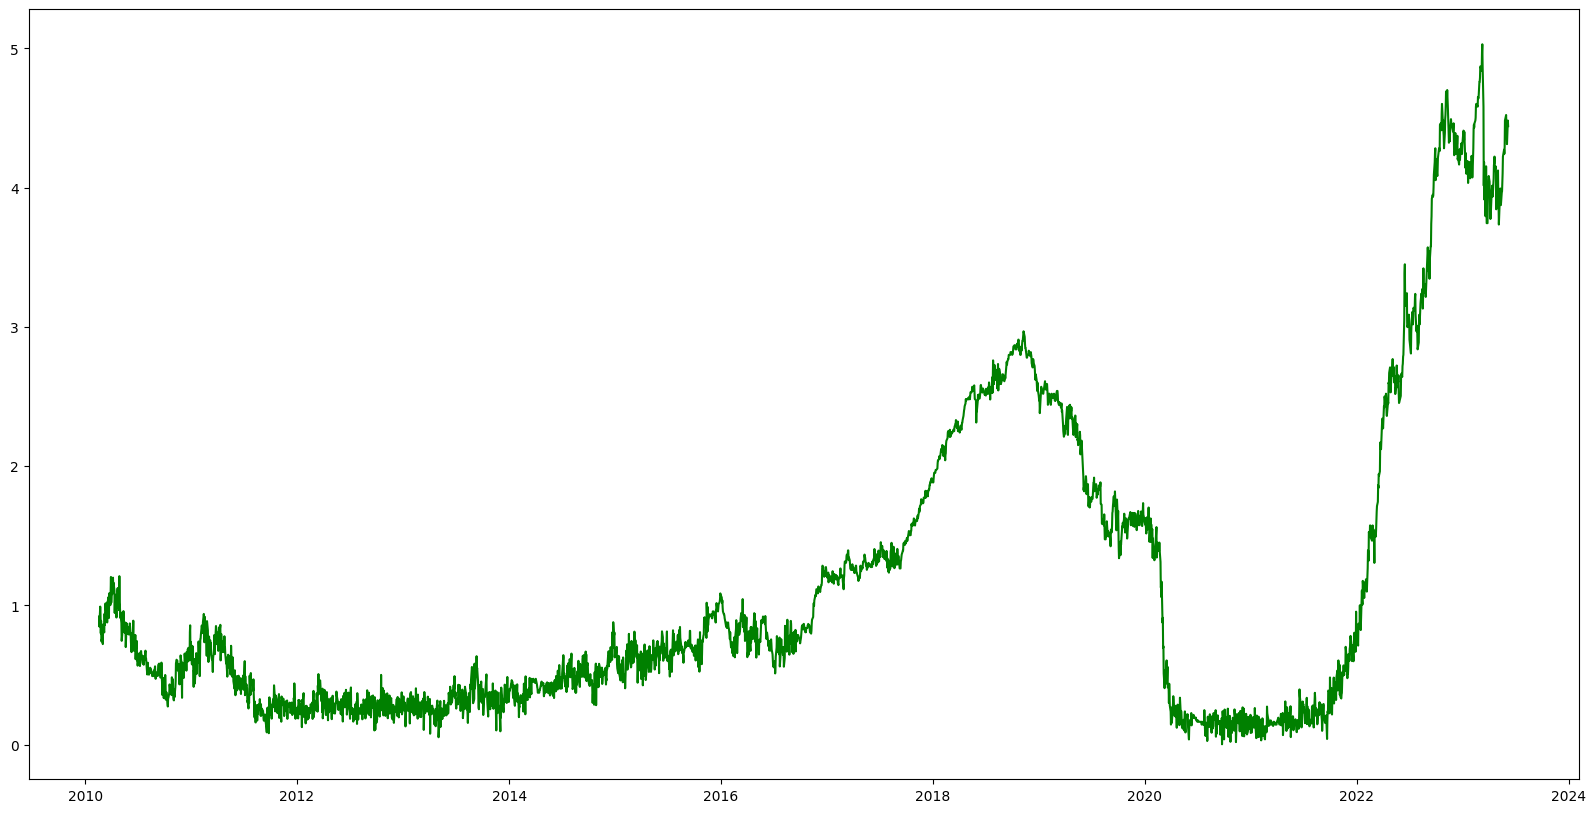

In [37]:
plt.figure(figsize=(20,10))
target = '2 Yr'
l1,= plt.plot(Now_DB[target+'_pred_1'],'g-')
l2,= plt.plot(Now_DB[target+'_pred_2'],'b-',markersize=4, alpha = 0.5)
l3, = plt.plot(Now_DB[target],'r-',markersize=4, alpha = 0.5)
plt.ylabel(target+' Par Yield Rate',fontsize = 20)
plt.legend(handles=[l1, l2, l3], labels=['Euler', 'Milstein', 'Real 3Mo'], fontsize = 16)

# Yield Curve

In [ ]:
np.array([66,68,70,72,74,76,78,80,82,84,86])+1

array([67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87])

In [ ]:
Now_DB.columns[[0,6,12,18,24,30,36,42,48,54,60,66]]

Index(['1 Mo', '3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr',
       '20 Yr', '30 Yr', '1 Mo_pred_1'],
      dtype='object')

Text(0.5, 1.0, 'Yield Curve')

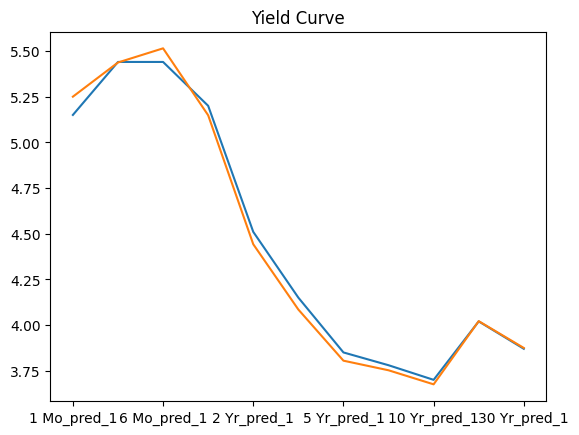

In [38]:
yc_real = Now_DB[Now_DB.columns[[0,6,12,18,24,30,36,42,48,54,60]]]
yc_real.loc['2023-06-06'].plot()

yc_pre1 = Now_DB[Now_DB.columns[[66,67,68,69,70,71,72,73,74,75,76]]]
yc_pre1.loc['2023-06-06'].plot()

# yc_pre2 = Now_DB[Now_DB.columns[[67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87]]]
# yc_pre2.loc['2023-06-06'].plot()

plt.title('Yield Curve')



# Error Calculated : RMSE MSE SSE

In [39]:
# MSE
MSE = np.sum((np.array(yc_pre1)  - np.array(yc_real))**2)/len(yc_pre1)

# RMSE
RMSE = np.sqrt(MSE)

# MAPE
MAPE = np.sum(np.abs((Now_DB[target+'_pred_1']-Now_DB[target])/DB[target]))/len(Now_DB)

In [40]:
MSE

0.033965796537258744

# Vacisek